# Import Library yang Digunakan

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

# Data Overview

In [2]:
# from google.colab import drive

# drive.mount('/content/drive')
# path = '/content/drive/MyDrive/TA/aqi_jakarta_data.csv'

In [3]:
df = pd.read_csv('aqi_jakarta_data.csv')

In [4]:
df.head()

,Date,City,Country,Status,AQI_Value
0,6/3/2022,Jakarta,Indonesia,Moderate,79.0
1,6/4/2022,Jakarta,Indonesia,Moderate,99.0
2,6/5/2022,Jakarta,Indonesia,Unhealthy for Sensitive Groups,122.0
3,6/6/2022,Jakarta,Indonesia,Unhealthy for Sensitive Groups,126.0
4,6/7/2022,Jakarta,Indonesia,Unhealthy for Sensitive Groups,117.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 455 entries, 0 to 454
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       455 non-null    object 
 1   City       455 non-null    object 
 2   Country    455 non-null    object 
 3   Status     455 non-null    object 
 4   AQI_Value  455 non-null    float64
dtypes: float64(1), object(4)
memory usage: 17.9+ KB


In [6]:
df.isnull().sum()

Date         0
City         0
Country      0
Status       0
AQI_Value    0
dtype: int64

In [7]:
df.describe()

,AQI_Value
count,455.000000
mean,103.123077
std,31.870163
min,28.000000
25%,78.000000
50%,106.000000
75%,130.000000
max,162.000000


# Interpolasi (Data Fixing)

In [8]:
#  METODE INTERPOLASI
from scipy.interpolate import interp1d

indices = ~np.isnan(df['AQI_Value'])
x = np.arange(len(df['AQI_Value']))
x_interp = x[indices]
y_interp = df['AQI_Value'][indices]

interp_func = interp1d(x_interp, y_interp, kind='linear', fill_value='extrapolate')
interpolated_data = interp_func(x)
for i, row in df.iterrows():
    if pd.isna(row['AQI_Value']):
        df.at[i, 'AQI_Value'] = interpolated_data[i]

# print(interpolated_data)
print(df.loc [265:271])

          Date     City    Country    Status  AQI_Value
265  2/23/2023  Jakarta  Indonesia      Good       44.0
266  2/24/2023  Jakarta  Indonesia      Good       45.0
267  2/25/2023  Jakarta  Indonesia      Good       47.0
268  2/26/2023  Jakarta  Indonesia      Good       49.0
269  2/27/2023  Jakarta  Indonesia      Good       51.0
270  2/28/2023  Jakarta  Indonesia  Moderate       53.0
271   3/1/2023  Jakarta  Indonesia  Moderate       55.0


# Min Max Scaling

In [9]:
from sklearn.preprocessing import MinMaxScaler

In [10]:
# Memilih kolom yang ingin dinormalisasi (ganti 'kolom' dengan nama kolom yang sesuai)
kolom = 'AQI_Value'
data_to_scale = df[[kolom]]

# Inisialisasi MinMaxScaler
scaler = MinMaxScaler()

# Melakukan Min-Max scaling pada kolom yang dipilih
scaled_data = scaler.fit_transform(data_to_scale)

# Membuat DataFrame baru dengan data yang telah dinormalisasi
data_scaled = pd.DataFrame(scaled_data, columns=[kolom+'_scaled'])

# Gabungkan data yang telah dinormalisasi dengan data asli
data_minmax = pd.concat([df['Date'], data_scaled], axis=1)

# Hasil scaling
print("Data Asli:")
print(df[['Date', 'AQI_Value']])
print("\nData yang Telah Dinormalisasi:")
print(data_minmax)

Data Asli:
          Date  AQI_Value
0     6/3/2022       79.0
1     6/4/2022       99.0
2     6/5/2022      122.0
3     6/6/2022      126.0
4     6/7/2022      117.0
..         ...        ...
450  8/27/2023      102.0
451  8/28/2023      136.0
452  8/29/2023      119.0
453  8/30/2023      131.0
454  8/31/2023      136.0

[455 rows x 2 columns]

Data yang Telah Dinormalisasi:
          Date  AQI_Value_scaled
0     6/3/2022          0.380597
1     6/4/2022          0.529851
2     6/5/2022          0.701493
3     6/6/2022          0.731343
4     6/7/2022          0.664179
..         ...               ...
450  8/27/2023          0.552239
451  8/28/2023          0.805970
452  8/29/2023          0.679104
453  8/30/2023          0.768657
454  8/31/2023          0.805970

[455 rows x 2 columns]


# Data *Splitting*

1. 70:30
2. 80:20
3. 90:10

In [11]:
df1 = data_minmax['AQI_Value_scaled']

In [12]:
# from sklearn.model_selection import train_test_split

# Memisahkan data menjadi data pelatihan dan pengujian dengan perbandingan 70:30
train_size_70 = int(0.7 * len(df1))

# Memisahkan data menjadi data pelatihan dan pengujian dengan perbandingan 80:20
train_size_80 = int(0.8 * len(df1))

# Memisahkan data menjadi data pelatihan dan pengujian dengan perbandingan 90:10
train_size_90 = int(0.9 * len(df1))


# Memisahkan data menjadi data pelatihan dan pengujian
train_70 = df1[:train_size_70]
test_30 = df1[train_size_70:]

train_80 = df1[:train_size_80]
test_20 = df1[train_size_80:]

train_90 = df1[:train_size_90]
test_10 = df1[train_size_90:]

#Single Exponential Smoothing Test

##1st Test  (70:30)

###PSO in Single Exponential Smoothing

In [13]:
# Inisialisasi dataset
train_db = np.asarray(train_70)  # Gunakan data pelatihan untuk peramalan
test_db = np.asarray(test_30)    # Gunakan data pengujian untuk evaluasi

In [14]:
alpha_values = np.random.uniform(0, 1, 3)
V = np.random.uniform(0, 1, 3)

pbest = alpha_values
pbest_obj = []

c1 = 1/2
c2 = 1
w = 1

In [15]:
for i in range (len(alpha_values)):
  forecast = np.zeros(len(train_db))
  pt = train_db[0]
  forecast[0] = pt

  for j in range(1, len(train_db)):
    pt = pt + alpha_values[i] * (train_db[j - 1] - pt)
    forecast[j] = pt

  mae_values = np.mean(np.abs(train_db - forecast))
  pbest_obj.append(mae_values)

# print(mae_values, pbest_obj)
gbest = pbest[np.array(pbest_obj).argmin()]
gbest_obj = np.array(pbest_obj).min()

for k in range (100):
  r1 = 1
  r2 = 1
  V = w * V + c1*r1*(pbest - alpha_values) + c2*r2*(gbest-alpha_values)
  alpha_values = alpha_values + V

  obj = []

  for l in range (len(alpha_values)):
    forecast = np.zeros(len(train_db))
    pt = train_db[0]
    forecast[0] = pt

    for m in range(1, len(train_db)):
      pt = pt + alpha_values[l] * (train_db[m - 1] - pt)
      forecast[m] = pt

    mae_values = np.mean(np.abs(train_db - forecast))
    obj.append(mae_values)

  pbest[(pbest_obj >= obj)] = alpha_values[(pbest_obj >= obj)]
  pbest_obj = np.array([pbest_obj, obj]).min(axis=0)
  gbest = pbest[np.array(pbest_obj).argmin()]
  gbest_obj = np.array(pbest_obj).min()

  print("Iterasi", k+1)
  print(pbest, pbest_obj, gbest, gbest_obj)

Iterasi 1
[0.69030574 0.53537692 0.79407579] [0.12058698 0.1205894  0.12082856] 0.6903057380367524 0.1205869769356445
Iterasi 2
[0.69030574 0.53537692 0.79407579] [0.12058698 0.1205894  0.12082856] 0.6903057380367524 0.1205869769356445
Iterasi 3
[0.65435793 0.53537692 0.79407579] [0.12049785 0.1205894  0.12082856] 0.6543579343066936 0.12049784515618264
Iterasi 4
[0.59444493 0.53537692 0.79407579] [0.12043281 0.1205894  0.12082856] 0.594444928089929 0.1204328079029302
Iterasi 5
[0.59444493 0.56589222 0.79407579] [0.12043281 0.1204896  0.12082856] 0.594444928089929 0.1204328079029302
Iterasi 6
[0.59444493 0.56589222 0.79407579] [0.12043281 0.1204896  0.12082856] 0.594444928089929 0.1204328079029302
Iterasi 7
[0.59444493 0.56589222 0.69536817] [0.12043281 0.1204896  0.12059148] 0.594444928089929 0.1204328079029302
Iterasi 8
[0.59444493 0.56589222 0.69536817] [0.12043281 0.1204896  0.12059148] 0.594444928089929 0.1204328079029302
Iterasi 9
[0.59444493 0.56589222 0.69536817] [0.12043281 0.1

###Method Implementation

In [16]:
# Inisialisasi nilai alpha (parameter peramalan)
alpha = gbest
print('Nilai Parameter Alpha = ', alpha)

# Menginisialisasi hasil peramalan
train_forecast = np.zeros(len(train_db))
test_forecast = np.zeros(len(test_db))

# Inisialisasi nilai awal pt menggunakan data pelatihan
pt_train = train_db[0]
pt_test = train_db[-1]  # Gunakan nilai terakhir dari data pelatihan sebagai nilai awal untuk pengujian

train_forecast[0] = pt_train
test_forecast[0] = pt_test

# Melakukan peramalan eksponensial untuk data pelatihan
for i in range(1, len(train_db)):
    pt_train = pt_train + alpha * (train_db[i - 1] - pt_train)
    train_forecast[i] = pt_train

# Melakukan peramalan eksponensial untuk data pengujian
for i in range(1, len(test_db)):
    pt_test = pt_test + alpha * (train_forecast[-1] - pt_test)
    test_forecast[i] = pt_test

# Menghitung Evaluasi Model untuk data pelatihan
train_mae_score = np.mean(np.abs(train_db - train_forecast))
train_rmse_score = np.sqrt(np.mean((train_db - train_forecast) ** 2))

# Menghitung Evaluasi Model untuk data pengujian
test_mae_score = np.mean(np.abs(test_db - test_forecast))
test_rmse_score = np.sqrt(np.mean((test_db - test_forecast) ** 2))

print('Train Root Mean Squared Error (RMSE):', train_rmse_score)
print('Train Mean Absolute Error (MAE):', train_mae_score)
print('Test Root Mean Squared Error (RMSE):', test_rmse_score)
print('Test Mean Absolute Error (MAE):', test_mae_score)

Nilai Parameter Alpha =  0.6084279756699558
Train Root Mean Squared Error (RMSE): 0.1549221097645002
Train Mean Absolute Error (MAE): 0.12041906000465716
Test Root Mean Squared Error (RMSE): 0.4801813067225624
Test Mean Absolute Error (MAE): 0.4494613971377495


In [17]:
test_forecast_copy = np.copy(test_forecast)

# Peramalan untuk x hari ke depan setelah data terakhir
# forecast = int(input("Masukkan jumlah hari :"))
forecast = 30
for i in range(1, forecast + 1):
    pt_test = pt_test + alpha * (test_forecast[- 1] - pt_test)
    # pt_test = pt_test + alpha * (test_forecast[i - 1] - pt_test)
    test_forecast = np.append(test_forecast, pt_test)

##2nd Test (80:20)

###PSO in Single Exponential Smoothing

In [18]:
# Inisialisasi dataset
train_db1 = np.asarray(train_80)  # Gunakan data pelatihan untuk peramalan
test_db1 = np.asarray(test_20)    # Gunakan data pengujian untuk evaluasi

In [19]:
alpha_values = np.random.uniform(0, 1, 3)
V = np.random.uniform(0, 1, 3)

pbest = alpha_values
pbest_obj = []

c1 = 1/2
c2 = 1
w = 1

In [20]:
for i in range (len(alpha_values)):
  forecast = np.zeros(len(train_db1))
  pt = train_db1[0]
  forecast[0] = pt

  for j in range(1, len(train_db1)):
    pt = pt + alpha_values[i] * (train_db1[j - 1] - pt)
    forecast[j] = pt

  mae_values = np.mean(np.abs(train_db1 - forecast))
  pbest_obj.append(mae_values)

# print(mae_values, pbest_obj)
gbest = pbest[np.array(pbest_obj).argmin()]
gbest_obj = np.array(pbest_obj).min()

for k in range (100):
  r1 = 1
  r2 = 1
  V = w * V + c1*r1*(pbest - alpha_values) + c2*r2*(gbest-alpha_values)
  alpha_values = alpha_values + V

  obj = []

  for l in range (len(alpha_values)):
    forecast = np.zeros(len(train_db1))
    pt = train_db1[0]
    forecast[0] = pt

    for m in range(1, len(train_db1)):
      pt = pt + alpha_values[l] * (train_db1[m - 1] - pt)
      forecast[m] = pt

    mae_values = np.mean(np.abs(train_db1 - forecast))
    obj.append(mae_values)

  pbest[(pbest_obj >= obj)] = alpha_values[(pbest_obj >= obj)]
  pbest_obj = np.array([pbest_obj, obj]).min(axis=0)
  gbest = pbest[np.array(pbest_obj).argmin()]
  gbest_obj = np.array(pbest_obj).min()

  print("Iterasi", k+1)
  print(pbest, pbest_obj, gbest, gbest_obj)

Iterasi 1
[0.81141985 0.61024274 0.30847307] [0.12171099 0.12052612 0.12259084] 0.6102427422314399 0.12052612450109114
Iterasi 2
[0.81141985 0.61024274 0.30847307] [0.12171099 0.12052612 0.12259084] 0.6102427422314399 0.12052612450109114
Iterasi 3
[0.81141985 0.61024274 0.30847307] [0.12171099 0.12052612 0.12259084] 0.6102427422314399 0.12052612450109114
Iterasi 4
[0.81141985 0.61024274 0.30847307] [0.12171099 0.12052612 0.12259084] 0.6102427422314399 0.12052612450109114
Iterasi 5
[0.81141985 0.61024274 0.58099353] [0.12171099 0.12052612 0.12048534] 0.5809935271211082 0.1204853399322987
Iterasi 6
[0.81141985 0.61024274 0.58099353] [0.12171099 0.12052612 0.12048534] 0.5809935271211082 0.1204853399322987
Iterasi 7
[0.6621044  0.61024274 0.58099353] [0.12076844 0.12052612 0.12048534] 0.5809935271211082 0.1204853399322987
Iterasi 8
[0.6621044  0.61024274 0.58099353] [0.12076844 0.12052612 0.12048534] 0.5809935271211082 0.1204853399322987
Iterasi 9
[0.6621044  0.61024274 0.58099353] [0.1207

###Method Implementation

In [21]:
# Inisialisasi nilai alpha (parameter peramalan)
alpha = gbest
print('Nilai Parameter Alpha = ', alpha)

# Menginisialisasi hasil peramalan
train_forecast1 = np.zeros(len(train_db1))
test_forecast1 = np.zeros(len(test_db1))

# Inisialisasi nilai awal pt menggunakan data pelatihan
pt_train = train_db1[0]
pt_test = train_db1[-1]  # Gunakan nilai terakhir dari data pelatihan sebagai nilai awal untuk pengujian

train_forecast1[0] = pt_train
test_forecast1[0] = pt_test

# Melakukan peramalan eksponensial untuk data pelatihan
for i in range(1, len(train_db1)):
    pt_train = pt_train + alpha * (train_db1[i - 1] - pt_train)
    train_forecast1[i] = pt_train

# Melakukan peramalan eksponensial untuk data pengujian
for i in range(1, len(test_db1)):
    pt_test = pt_test + alpha * (train_forecast1[- 1] - pt_test)
    test_forecast1[i] = pt_test

# Menghitung Evaluasi Model untuk data pelatihan
train_mae_score = np.mean(np.abs(train_db1 - train_forecast1))
train_rmse_score = np.sqrt(np.mean((train_db1 - train_forecast1) ** 2))

# Menghitung Evaluasi Model untuk data pengujian
test_mae_score = np.mean(np.abs(test_db1 - test_forecast1))
test_rmse_score = np.sqrt(np.mean((test_db1 - test_forecast1) ** 2))

print('Train Root Mean Squared Error (RMSE):', train_rmse_score)
print('Train Mean Absolute Error (MAE):', train_mae_score)
print('Test Root Mean Squared Error (RMSE):', test_rmse_score)
print('Test Mean Absolute Error (MAE):', test_mae_score)

Nilai Parameter Alpha =  0.5694448373067009
Train Root Mean Squared Error (RMSE): 0.15526099954156497
Train Mean Absolute Error (MAE): 0.12047768964347415
Test Root Mean Squared Error (RMSE): 0.14399849867915973
Test Mean Absolute Error (MAE): 0.1094550652263757


In [22]:
test_forecast_copy1 = np.copy(test_forecast1)

# Peramalan untuk x hari ke depan setelah data terakhir
# forecast = int(input("Masukkan jumlah hari :"))
forecast = 30
for i in range(1, forecast + 1):
    pt_test = pt_test + alpha * (test_forecast1[- 1] - pt_test)
    # pt_test = pt_test + alpha * (test_forecast[i - 1] - pt_test)
    test_forecast1 = np.append(test_forecast1, pt_test)

# Cetak hasil peramalan
print("Hasil peramalan untuk", forecast,"hari ke depan setelah data terakhir:")
for i, forecast in enumerate(test_forecast1[len(test_db1):]):
    print(f"Peramalan untuk hari {i + 1}: {forecast:.2f}")

Hasil peramalan untuk 30 hari ke depan setelah data terakhir:
Peramalan untuk hari 1: 0.81
Peramalan untuk hari 2: 0.81
Peramalan untuk hari 3: 0.81
Peramalan untuk hari 4: 0.81
Peramalan untuk hari 5: 0.81
Peramalan untuk hari 6: 0.81
Peramalan untuk hari 7: 0.81
Peramalan untuk hari 8: 0.81
Peramalan untuk hari 9: 0.81
Peramalan untuk hari 10: 0.81
Peramalan untuk hari 11: 0.81
Peramalan untuk hari 12: 0.81
Peramalan untuk hari 13: 0.81
Peramalan untuk hari 14: 0.81
Peramalan untuk hari 15: 0.81
Peramalan untuk hari 16: 0.81
Peramalan untuk hari 17: 0.81
Peramalan untuk hari 18: 0.81
Peramalan untuk hari 19: 0.81
Peramalan untuk hari 20: 0.81
Peramalan untuk hari 21: 0.81
Peramalan untuk hari 22: 0.81
Peramalan untuk hari 23: 0.81
Peramalan untuk hari 24: 0.81
Peramalan untuk hari 25: 0.81
Peramalan untuk hari 26: 0.81
Peramalan untuk hari 27: 0.81
Peramalan untuk hari 28: 0.81
Peramalan untuk hari 29: 0.81
Peramalan untuk hari 30: 0.81


##3rd Test (90:10)

###PSO in Single Exponential Smoothing

In [23]:
# Inisialisasi dataset
train_db2 = np.asarray(train_90)  # Gunakan data pelatihan untuk peramalan
test_db2 = np.asarray(test_10)    # Gunakan data pengujian untuk evaluasi

In [24]:
alpha_values = np.random.uniform(0, 1, 3)
V = np.random.uniform(0, 1, 3)

pbest = alpha_values
pbest_obj = []

c1 = 1/2
c2 = 1
w = 1

In [25]:
for i in range (len(alpha_values)):
  forecast = np.zeros(len(train_db2))
  pt = train_db2[0]
  forecast[0] = pt

  for j in range(1, len(train_db2)):
    pt = pt + alpha_values[i] * (train_db2[j - 1] - pt)
    forecast[j] = pt

  mae_values = np.mean(np.abs(train_db2 - forecast))
  pbest_obj.append(mae_values)

# print(mae_values, pbest_obj)
gbest = pbest[np.array(pbest_obj).argmin()]
gbest_obj = np.array(pbest_obj).min()

for k in range (100):
  r1 = 1
  r2 = 1
  V = w * V + c1*r1*(pbest - alpha_values) + c2*r2*(gbest-alpha_values)
  alpha_values = alpha_values + V

  obj = []

  for l in range (len(alpha_values)):
    forecast = np.zeros(len(train_db2))
    pt = train_db2[0]
    forecast[0] = pt

    for m in range(1, len(train_db2)):
      pt = pt + alpha_values[l] * (train_db2[m - 1] - pt)
      forecast[m] = pt

    mae_values = np.mean(np.abs(train_db2 - forecast))
    obj.append(mae_values)

  pbest[(pbest_obj >= obj)] = alpha_values[(pbest_obj >= obj)]
  pbest_obj = np.array([pbest_obj, obj]).min(axis=0)
  gbest = pbest[np.array(pbest_obj).argmin()]
  gbest_obj = np.array(pbest_obj).min()

  print("Iterasi", k+1)
  print(pbest, pbest_obj, gbest, gbest_obj)

Iterasi 1
[0.08618395 0.41676379 0.75483617] [0.13440845 0.11913483 0.11901114] 0.7548361729404847 0.11901113824261658
Iterasi 2
[0.08618395 0.41676379 0.75483617] [0.13440845 0.11913483 0.11901114] 0.7548361729404847 0.11901113824261658
Iterasi 3
[0.08618395 0.41676379 0.75483617] [0.13440845 0.11913483 0.11901114] 0.7548361729404847 0.11901113824261658
Iterasi 4
[0.08618395 0.41676379 0.75483617] [0.13440845 0.11913483 0.11901114] 0.7548361729404847 0.11901113824261658
Iterasi 5
[0.48784    0.41676379 0.75483617] [0.11861917 0.11913483 0.11901114] 0.48784000038871134 0.11861916812535302
Iterasi 6
[0.48784    0.41676379 0.75483617] [0.11861917 0.11913483 0.11901114] 0.48784000038871134 0.11861916812535302
Iterasi 7
[0.48784    0.69855583 0.51350224] [0.11861917 0.11877189 0.11849315] 0.5135022432669051 0.11849314773098035
Iterasi 8
[0.48784    0.69855583 0.51350224] [0.11861917 0.11877189 0.11849315] 0.5135022432669051 0.11849314773098035
Iterasi 9
[0.48784    0.69855583 0.51350224] [

###Method Implementation

In [26]:
# Inisialisasi nilai alpha (parameter peramalan)
alpha = gbest
print('Nilai Parameter Alpha = ', alpha)

# Menginisialisasi hasil peramalan
train_forecast2 = np.zeros(len(train_db2))
test_forecast2 = np.zeros(len(test_db2))

# Inisialisasi nilai awal pt menggunakan data pelatihan
pt_train = train_db2[0]
pt_test = train_db2[-1]  # Gunakan nilai terakhir dari data pelatihan sebagai nilai awal untuk pengujian

train_forecast2[0] = pt_train
test_forecast2[0] = pt_test

# Melakukan peramalan eksponensial untuk data pelatihan
for i in range(1, len(train_db2)):
    pt_train = pt_train + alpha * (train_db2[i - 1] - pt_train)
    train_forecast2[i] = pt_train

# Melakukan peramalan eksponensial untuk data pengujian
for i in range(1, len(test_db2)):
    pt_test = pt_test + alpha * (train_forecast2[- 1] - pt_test)
    test_forecast2[i] = pt_test

# Menghitung Evaluasi Model untuk data pelatihan
train_mae_score = np.mean(np.abs(train_db2 - train_forecast2))
train_rmse_score = np.sqrt(np.mean((train_db2 - train_forecast2) ** 2))

# Menghitung Evaluasi Model untuk data pengujian
test_mae_score = np.mean(np.abs(test_db2 - test_forecast2))
test_rmse_score = np.sqrt(np.mean((test_db2 - test_forecast2) ** 2))

print('Train Root Mean Squared Error (RMSE):', train_rmse_score)
print('Train Mean Absolute Error (MAE):', train_mae_score)
print('Test Root Mean Squared Error (RMSE):', test_rmse_score)
print('Test Mean Absolute Error (MAE):', test_mae_score)

Nilai Parameter Alpha =  0.5630046958598761
Train Root Mean Squared Error (RMSE): 0.1532481606416814
Train Mean Absolute Error (MAE): 0.11836518588401784
Test Root Mean Squared Error (RMSE): 0.11330214588641928
Test Mean Absolute Error (MAE): 0.08945329648477676


In [27]:
test_forecast_copy2 = np.copy(test_forecast2)

# Peramalan untuk x hari ke depan setelah data terakhir
# forecast = int(input("Masukkan jumlah hari :"))
forecast = 30
for i in range(1, forecast + 1):
    pt_test = pt_test + alpha * (test_forecast2[- 1] - pt_test)
    # pt_test = pt_test + alpha * (test_forecast2[i - 1] - pt_test)
    test_forecast2 = np.append(test_forecast2, pt_test)

# Cetak hasil peramalan
print("Hasil peramalan untuk", forecast,"hari ke depan setelah data terakhir:")
for i, forecast in enumerate(test_forecast2[len(test_db2):]):
    print(f"Peramalan untuk hari {i + 1}: {forecast:.2f}")

Hasil peramalan untuk 30 hari ke depan setelah data terakhir:
Peramalan untuk hari 1: 0.79
Peramalan untuk hari 2: 0.79
Peramalan untuk hari 3: 0.79
Peramalan untuk hari 4: 0.79
Peramalan untuk hari 5: 0.79
Peramalan untuk hari 6: 0.79
Peramalan untuk hari 7: 0.79
Peramalan untuk hari 8: 0.79
Peramalan untuk hari 9: 0.79
Peramalan untuk hari 10: 0.79
Peramalan untuk hari 11: 0.79
Peramalan untuk hari 12: 0.79
Peramalan untuk hari 13: 0.79
Peramalan untuk hari 14: 0.79
Peramalan untuk hari 15: 0.79
Peramalan untuk hari 16: 0.79
Peramalan untuk hari 17: 0.79
Peramalan untuk hari 18: 0.79
Peramalan untuk hari 19: 0.79
Peramalan untuk hari 20: 0.79
Peramalan untuk hari 21: 0.79
Peramalan untuk hari 22: 0.79
Peramalan untuk hari 23: 0.79
Peramalan untuk hari 24: 0.79
Peramalan untuk hari 25: 0.79
Peramalan untuk hari 26: 0.79
Peramalan untuk hari 27: 0.79
Peramalan untuk hari 28: 0.79
Peramalan untuk hari 29: 0.79
Peramalan untuk hari 30: 0.79


#Inverse Transform

In [28]:
#Denormalisasi data untuk menghasilkan nilai yang aktual

train_db_scaler = scaler.inverse_transform(train_db.reshape(-1,1))
test_db_scaler = scaler.inverse_transform(test_db.reshape(-1,1))
test_forecast_scaler = scaler.inverse_transform(test_forecast.reshape(-1,1))

train_db1_scaler = scaler.inverse_transform(train_db1.reshape(-1,1))
test_db1_scaler = scaler.inverse_transform(test_db1.reshape(-1,1))
test_forecast1_scaler = scaler.inverse_transform(test_forecast1.reshape(-1,1))

train_db2_scaler = scaler.inverse_transform(train_db2.reshape(-1,1))
test_db2_scaler = scaler.inverse_transform(test_db2.reshape(-1,1))
test_forecast2_scaler = scaler.inverse_transform(test_forecast2.reshape(-1,1))

#Visualisasi Data

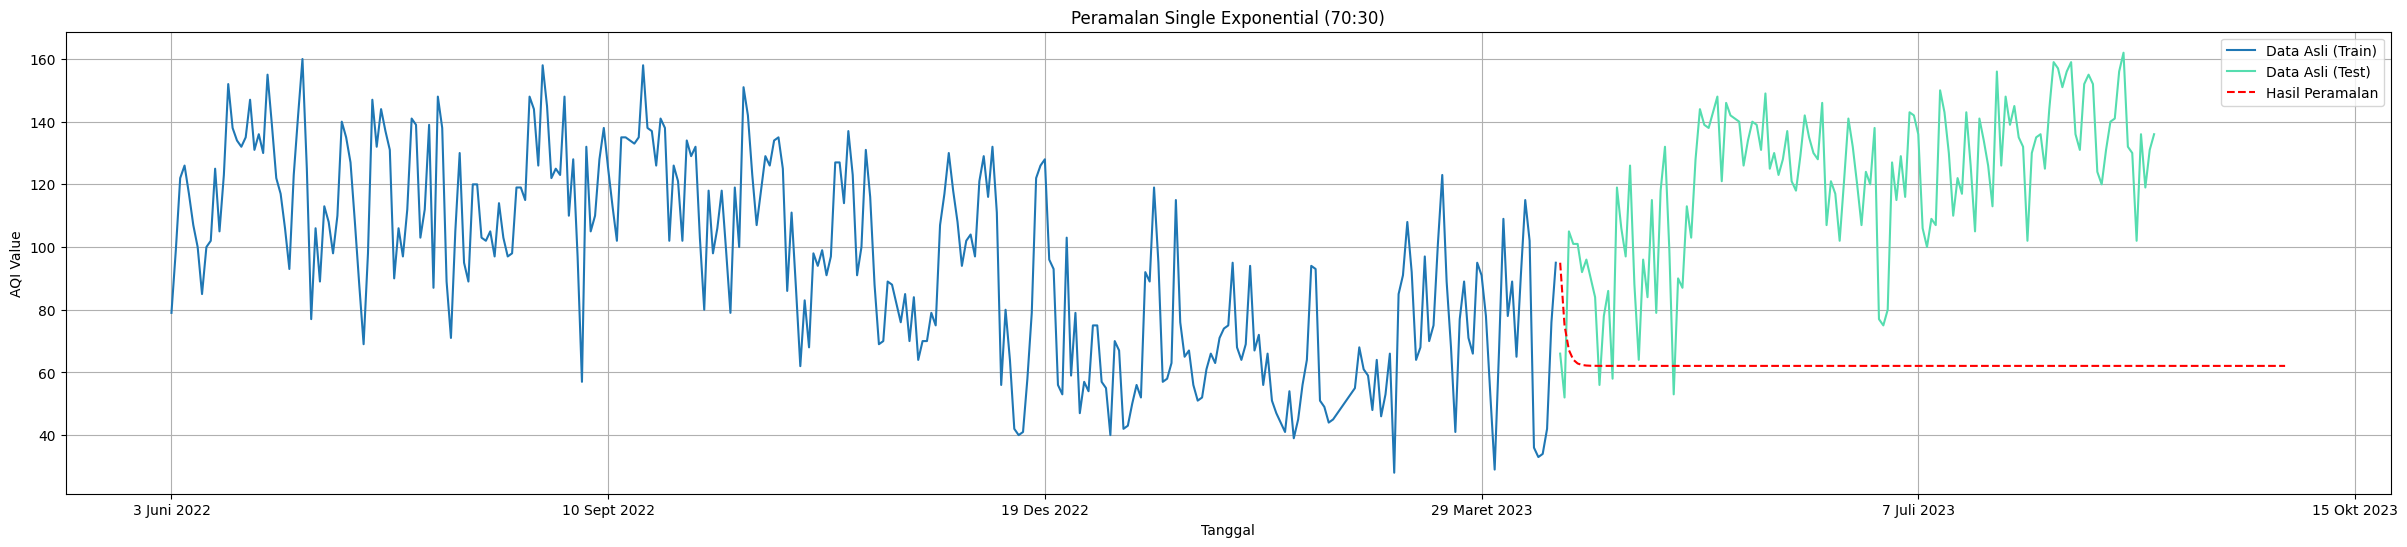

In [29]:
test_range = np.arange (len(train_db), len(train_db)+len(test_forecast))

# Visualisasi hasil peramalan untuk data pelatihan dan pengujian dalam satu grafik
plt.figure(figsize=(30, 6))  # Ukuran gambar
plt.plot(df['Date'][:len(train_db)], train_db_scaler, label='Data Asli (Train)')
plt.plot(df['Date'][-len(test_db):], test_db_scaler, label='Data Asli (Test)', color = '#55DDAF')
plt.plot(test_range, test_forecast_scaler, label='Hasil Peramalan', color = 'red', linestyle='dashed')

# Menambahkan label pada sumbu x dan y
plt.xlabel('Tanggal')
plt.ylabel('AQI Value')
plt.title('Peramalan Single Exponential (70:30)')
x = [0, 100, 200, 300, 400, 500]  # Menambahkan indeks untuk tanggal prediksi
x_labels = ['3 Juni 2022', '10 Sept 2022', '19 Des 2022', '29 Maret 2023', '7 Juli 2023', '15 Okt 2023']  # Menambahkan label untuk tanggal prediksi
plt.xticks(x, x_labels)

plt.grid(True)
plt.legend()
plt.show()

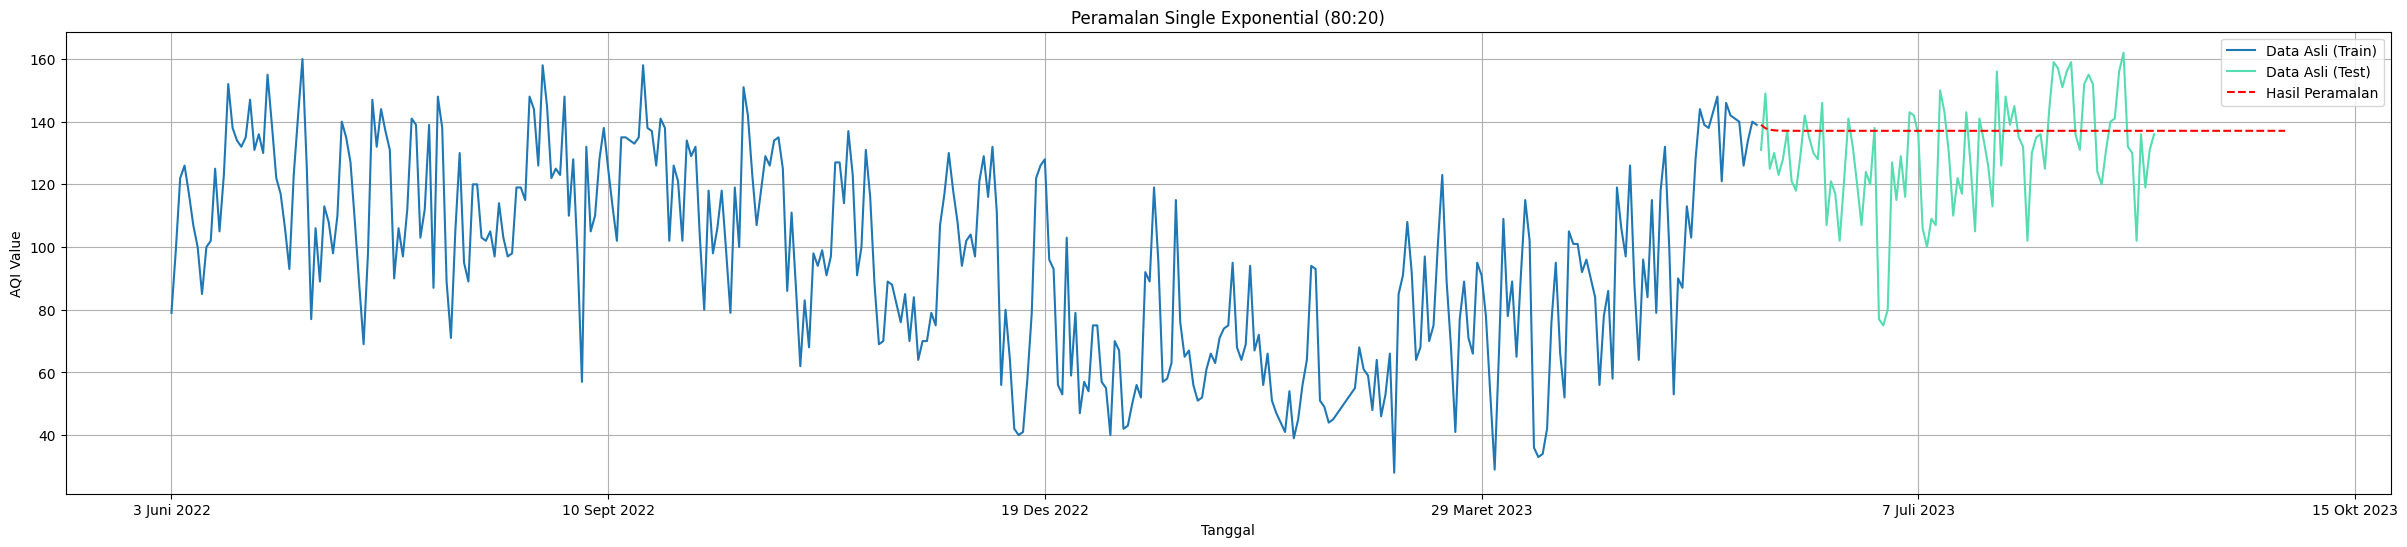

In [30]:
test_range = np.arange (len(train_db1), len(train_db1)+len(test_forecast1))

# Visualisasi hasil peramalan untuk data pelatihan dan pengujian dalam satu grafik
plt.figure(figsize=(30, 6))  # Ukuran gambar
plt.plot(df['Date'][:len(train_db1)], train_db1_scaler, label='Data Asli (Train)')
plt.plot(df['Date'][-len(test_db1):], test_db1_scaler, label='Data Asli (Test)', color = '#55DDAF')
plt.plot(test_range, test_forecast1_scaler, label='Hasil Peramalan', color ='red', linestyle='dashed')

# Menambahkan label pada sumbu x dan y
plt.xlabel('Tanggal')
plt.ylabel('AQI Value')
plt.title('Peramalan Single Exponential (80:20)')
x = [0, 100, 200, 300, 400, 500]  # Menambahkan indeks untuk tanggal prediksi
x_labels = ['3 Juni 2022', '10 Sept 2022', '19 Des 2022', '29 Maret 2023', '7 Juli 2023', '15 Okt 2023']  # Menambahkan label untuk tanggal prediksi
plt.xticks(x, x_labels)

plt.grid(True)
plt.legend()
plt.show()

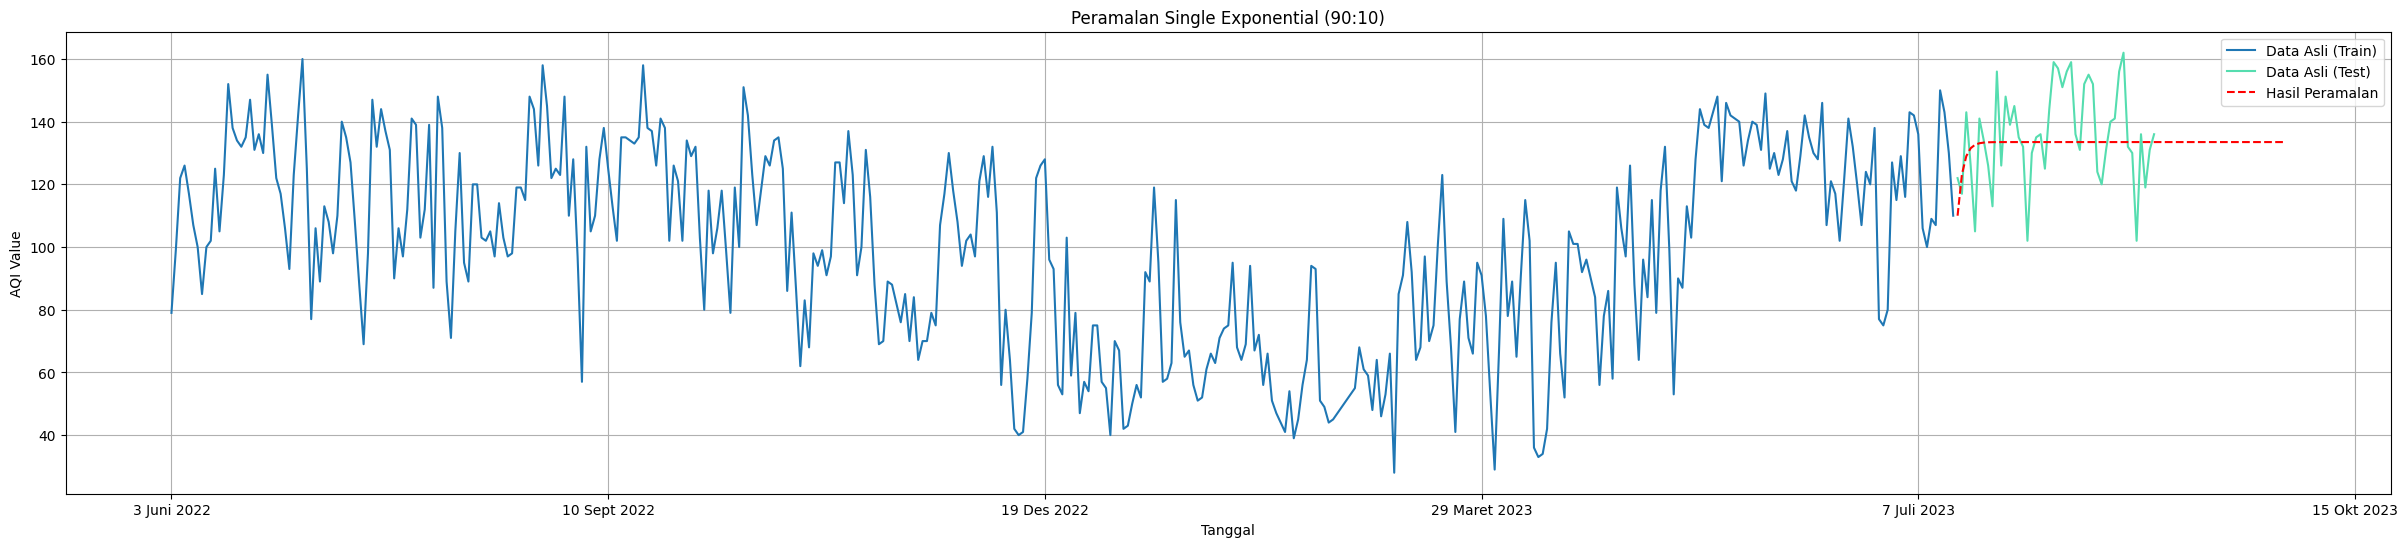

In [31]:
test_range = np.arange (len(train_db2), len(train_db2)+len(test_forecast2))

# Visualisasi hasil peramalan untuk data pelatihan dan pengujian dalam satu grafik
plt.figure(figsize=(30, 6))  # Ukuran gambar
plt.plot(df['Date'][:len(train_db2)], train_db2_scaler, label='Data Asli (Train)')
plt.plot(df['Date'][-len(test_db2):], test_db2_scaler, label='Data Asli (Test)', color = '#55DDAF')
plt.plot(test_range, test_forecast2_scaler, label='Hasil Peramalan', color ='red', linestyle='dashed')

# Menambahkan label pada sumbu x dan y
plt.xlabel('Tanggal')
plt.ylabel('AQI Value')
plt.title('Peramalan Single Exponential (90:10)')
x = [0, 100, 200, 300, 400, 500]  # Menambahkan indeks untuk tanggal prediksi
x_labels = ['3 Juni 2022', '10 Sept 2022', '19 Des 2022', '29 Maret 2023', '7 Juli 2023', '15 Okt 2023']  # Menambahkan label untuk tanggal prediksi
plt.xticks(x, x_labels)

plt.grid(True)
plt.legend()
plt.show()

#FORECAST

In [32]:
alpha_values = np.random.uniform(0, 1, 3)
V = np.random.uniform(0, 1, 3)

pbest = alpha_values
pbest_obj = []

c1 = 1/2
c2 = 1
w = 1

In [33]:
for i in range (len(alpha_values)):
  forecast = np.zeros(len(df1))
  pt = df1[0]
  forecast[0] = pt

  for j in range(1, len(df1)):
    pt = pt + alpha_values[i] * (df1[j - 1] - pt)
    forecast[j] = pt

  mae_values = np.mean(np.abs(df1 - forecast))
  pbest_obj.append(mae_values)

# print(mae_values, pbest_obj)
gbest = pbest[np.array(pbest_obj).argmin()]
gbest_obj = np.array(pbest_obj).min()

for k in range (100):
  r1 = 1
  r2 = 1
  V = w * V + c1*r1*(pbest - alpha_values) + c2*r2*(gbest-alpha_values)
  alpha_values = alpha_values + V

  obj = []

  for l in range (len(alpha_values)):
    forecast = np.zeros(len(df1))
    pt = df1[0]
    forecast[0] = pt

    for m in range(1, len(df1)):
      pt = pt + alpha_values[l] * (df1[m - 1] - pt)
      forecast[m] = pt

    mae_values = np.mean(np.abs(df1 - forecast))
    obj.append(mae_values)

  pbest[(pbest_obj >= obj)] = alpha_values[(pbest_obj >= obj)]
  pbest_obj = np.array([pbest_obj, obj]).min(axis=0)
  gbest = pbest[np.array(pbest_obj).argmin()]
  gbest_obj = np.array(pbest_obj).min()

  print("Iterasi", k+1)
  print(pbest, pbest_obj, gbest, gbest_obj)

Iterasi 1
[0.85366584 0.70580158 0.72844704] [0.11840274 0.1162724  0.11692755] 0.7058015833669902 0.11627239973461932
Iterasi 2
[0.85366584 0.70580158 0.72844704] [0.11840274 0.1162724  0.11692755] 0.7058015833669902 0.11627239973461932
Iterasi 3
[0.85366584 0.70580158 0.72844704] [0.11840274 0.1162724  0.11692755] 0.7058015833669902 0.11627239973461932
Iterasi 4
[0.28343492 0.53593606 0.72844704] [0.11822689 0.11618684 0.11692755] 0.5359360649951224 0.11618683674291216
Iterasi 5
[0.28343492 0.53593606 0.72844704] [0.11822689 0.11618684 0.11692755] 0.5359360649951224 0.11618683674291216
Iterasi 6
[0.33485846 0.53593606 0.68319576] [0.11752386 0.11618684 0.11672729] 0.5359360649951224 0.11618683674291216
Iterasi 7
[0.33485846 0.53593606 0.68319576] [0.11752386 0.11618684 0.11672729] 0.5359360649951224 0.11618683674291216
Iterasi 8
[0.33485846 0.53593606 0.68319576] [0.11752386 0.11618684 0.11672729] 0.5359360649951224 0.11618683674291216
Iterasi 9
[0.33485846 0.53593606 0.68319576] [0.

In [34]:
# Inisialisasi nilai alpha (parameter peramalan)
alpha = gbest
print('Nilai Parameter Alpha = ', alpha)

# Menginisialisasi hasil peramalan
df1_forecast = np.zeros(len(df1))

# Inisialisasi nilai awal pt menggunakan data pelatihan
pt = df1[0]
df1_forecast[0] = pt

# Melakukan peramalan eksponensial untuk data pelatihan
for i in range(1, len(df1)):
    pt = pt + alpha * (df1[i - 1] - pt)
    df1_forecast[i] = pt

Nilai Parameter Alpha =  0.5299323047604573


In [35]:
# Simpan model atau parameter peramalan ke dalam objek
ses_model = {'alpha': alpha, 'pt': pt}

# Dump model ke file menggunakan pickle
with open('SES_Model_Prediksi.sav', 'wb') as file:
    pickle.dump(ses_model, file)

In [36]:
# Peramalan untuk x hari ke depan setelah data terakhir
forecast_days = 30
forecast_results = np.zeros(forecast_days)

for i in range(1, forecast_days + 1):
    pt = pt + alpha * (df1_forecast[-1] - pt)
    df1_forecast = np.append(df1_forecast, pt)
    forecast_results[i - 1] = pt

# Cetak hasil peramalan
print("Hasil peramalan untuk", forecast_days, "hari ke depan setelah data terakhir:")
for i, forecast in enumerate(forecast_results):
    print(f"Peramalan untuk hari {i + 1}: {forecast:.2f}")

Hasil peramalan untuk 30 hari ke depan setelah data terakhir:
Peramalan untuk hari 1: 0.74
Peramalan untuk hari 2: 0.74
Peramalan untuk hari 3: 0.74
Peramalan untuk hari 4: 0.74
Peramalan untuk hari 5: 0.74
Peramalan untuk hari 6: 0.74
Peramalan untuk hari 7: 0.74
Peramalan untuk hari 8: 0.74
Peramalan untuk hari 9: 0.74
Peramalan untuk hari 10: 0.74
Peramalan untuk hari 11: 0.74
Peramalan untuk hari 12: 0.74
Peramalan untuk hari 13: 0.74
Peramalan untuk hari 14: 0.74
Peramalan untuk hari 15: 0.74
Peramalan untuk hari 16: 0.74
Peramalan untuk hari 17: 0.74
Peramalan untuk hari 18: 0.74
Peramalan untuk hari 19: 0.74
Peramalan untuk hari 20: 0.74
Peramalan untuk hari 21: 0.74
Peramalan untuk hari 22: 0.74
Peramalan untuk hari 23: 0.74
Peramalan untuk hari 24: 0.74
Peramalan untuk hari 25: 0.74
Peramalan untuk hari 26: 0.74
Peramalan untuk hari 27: 0.74
Peramalan untuk hari 28: 0.74
Peramalan untuk hari 29: 0.74
Peramalan untuk hari 30: 0.74


In [37]:
#Denormalisasi data untuk menghasilkan nilai yang aktual
df1_array = df1.values.reshape(-1, 1)
df1_scaler = scaler.inverse_transform(df1_array)
forecast_results_scaler = scaler.inverse_transform(forecast_results.reshape(-1,1))

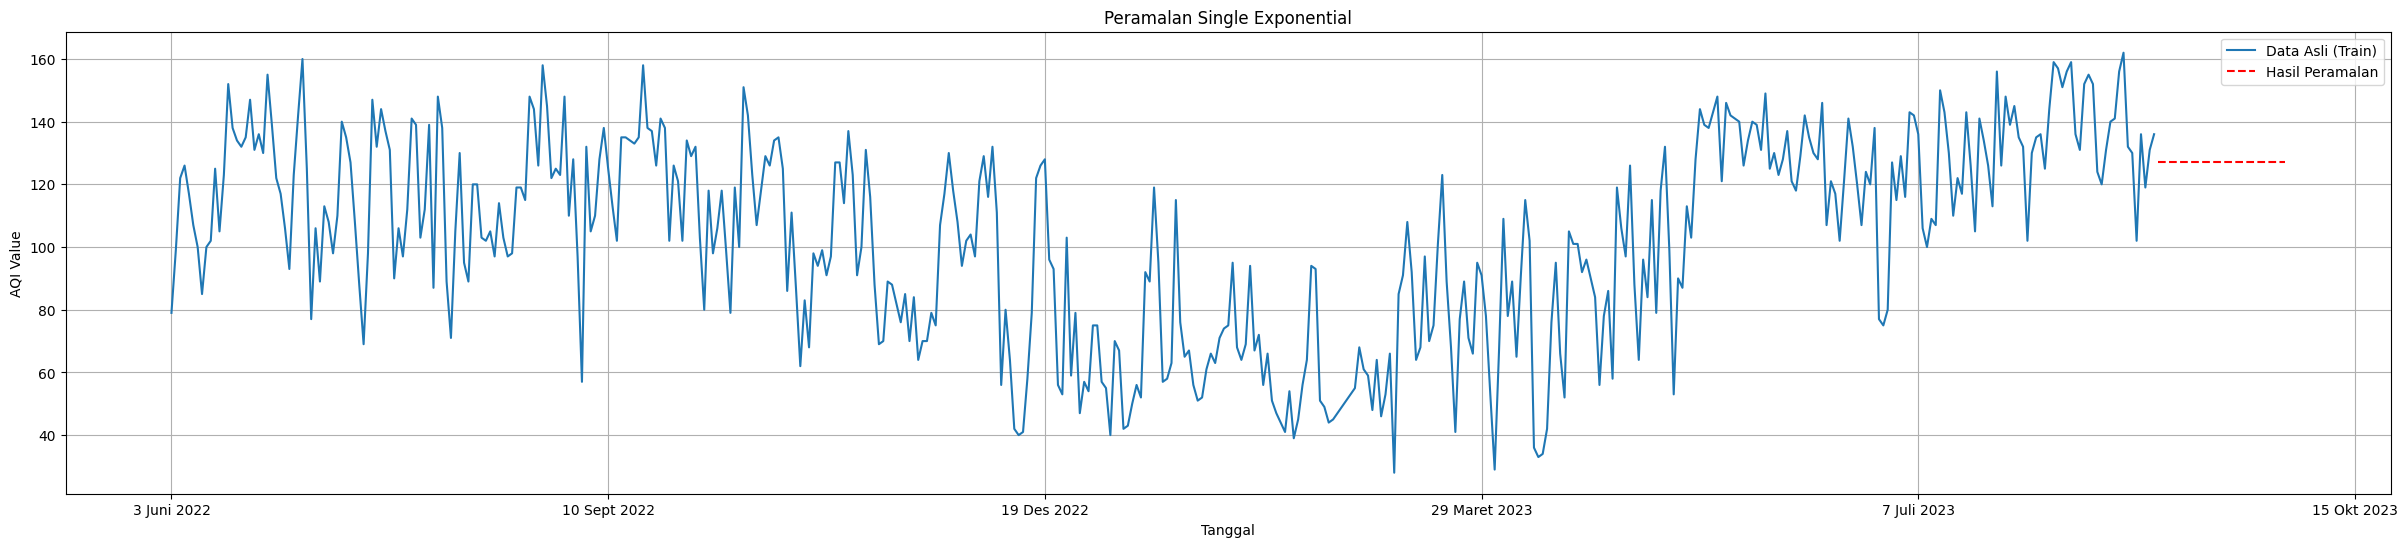

In [38]:
test_range = np.arange (len(df), len(df)+len(forecast_results))

# Visualisasi hasil peramalan untuk data pelatihan dan pengujian dalam satu grafik
plt.figure(figsize=(30, 6))  # Ukuran gambar
plt.plot(df['Date'][:len(df)], df1_scaler, label='Data Asli (Train)')
plt.plot(test_range, forecast_results_scaler, label='Hasil Peramalan', color = 'red', linestyle='dashed')

# Menambahkan label pada sumbu x dan y
plt.xlabel('Tanggal')
plt.ylabel('AQI Value')
plt.title('Peramalan Single Exponential')
x = [0, 100, 200, 300, 400, 500]  # Menambahkan indeks untuk tanggal prediksi
x_labels = ['3 Juni 2022', '10 Sept 2022', '19 Des 2022', '29 Maret 2023', '7 Juli 2023', '15 Okt 2023']  # Menambahkan label untuk tanggal prediksi
plt.xticks(x, x_labels)

plt.grid(True)
plt.legend()
plt.show()